In [ ]:
from datasets import load_dataset
import json
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import pandas as pd
import openai
import random
import csv
from tqdm import tqdm
import re
from transformers import pipeline, set_seed

In [ ]:
# set seed for reproducibility 
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)   
set_seed(42)

# Load Dataset

In [ ]:
data_classes_two = np.load('../Data/classes_two.npy', allow_pickle=True)
data_classes = np.load('../Data/classes.npy', allow_pickle=True)

with open('../Data/dataset.json', 'r') as f:
    data = json.load(f)
with open('../Data/post_id_divisions.json', 'r') as f:
    post_id_divisions = json.load(f)
    


# Inspect Labels

In [5]:
examples_binary = [
    (" ".join(data[k]['post_tokens']), label)
    for k, label in zip(data.keys(), data_classes_two)
]

examples_multiclass = [
    (" ".join(data[k]['post_tokens']), label)
    for k, label in zip(data.keys(), data_classes)
]

# Analyse Annotator Disagreements

Total examples: 20148
Unanimous (all annotators agree): 9845 (48.86%)
Two-label disagreement: 9384 (46.58%)
Three-label disagreement: 919 (4.56%)


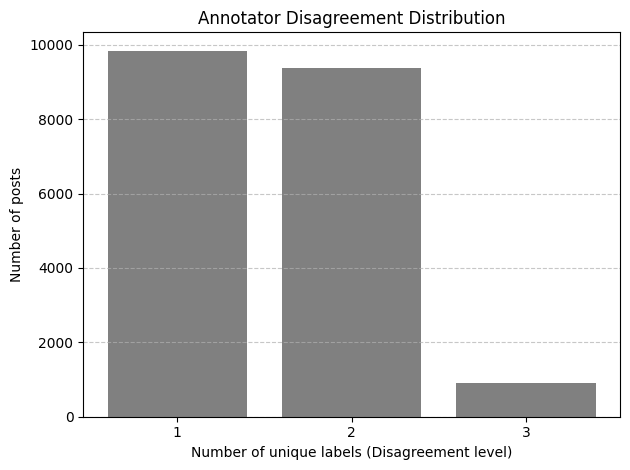


Post ID: 14971751_gab
Disagreement level: 3
Label counts: Counter({'normal': 1, 'offensive': 1, 'hatespeech': 1})
Text: i have upgraded your status from gangsta to playa this nigger here understands what real issues are due to his objectivity and foresight

Post ID: 1179080731642990592_twitter
Disagreement level: 3
Label counts: Counter({'offensive': 1, 'normal': 1, 'hatespeech': 1})
Text: <user> <user> <user> <user> <user> <user> <user> <user> do not be 😂 i do not need a faggot here for me u sinner 😔

Post ID: 25605196_gab
Disagreement level: 3
Label counts: Counter({'normal': 1, 'offensive': 1, 'hatespeech': 1})
Text: last nights black lighting show ov yea such miscasting jewy jewnose is the white guy forcing <number> niglets to deal drugs but blond hergerman is the comet pizza guy keeping powerful niggerette girls trapped in his basement pizzagate seriously visit dc sometime <user> <user> <user> <user> <user> ‍

Post ID: 1179083428924231680_twitter
Disagreement level: 3
Label count

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import json

def compute_annotator_disagreement(dataset, verbose=False, return_top_n=0, plot=False):
    """
    Compute the number of unique labels assigned by annotators for each post,
    and optionally plot disagreement distribution.
    
    Args:
        dataset (dict): Loaded JSON dataset
        verbose (bool): Print summary stats
        return_top_n (int): If >0, return top N most disagreed examples
        plot (bool): If True, plot a histogram of disagreement levels

    Returns:
        disagreement_stats (list of tuples): (post_id, disagreement_count, label_counter)
        top_disagreements (optional): top N posts with highest disagreement
    """
    disagreement_stats = []

    for post_id, content in dataset.items():
        labels = [ann['label'] for ann in content.get('annotators', [])]
        label_counter = Counter(labels)
        disagreement_count = len(label_counter)
        disagreement_stats.append((post_id, disagreement_count, label_counter))

    if verbose:
        total = len(disagreement_stats)
        unanimous = sum(1 for _, c, _ in disagreement_stats if c == 1)
        mild_disagreement = sum(1 for _, c, _ in disagreement_stats if c == 2)
        full_disagreement = sum(1 for _, c, _ in disagreement_stats if c >= 3)

        print(f"Total examples: {total}")
        print(f"Unanimous (all annotators agree): {unanimous} ({unanimous/total:.2%})")
        print(f"Two-label disagreement: {mild_disagreement} ({mild_disagreement/total:.2%})")
        print(f"Three-label disagreement: {full_disagreement} ({full_disagreement/total:.2%})")

    if plot:
        disagreement_counts = [c for _, c, _ in disagreement_stats]
        count_dist = Counter(disagreement_counts)
        plt.bar(count_dist.keys(), count_dist.values(), color='gray')
        plt.xlabel("Number of unique labels (Disagreement level)")
        plt.ylabel("Number of posts")
        plt.title("Annotator Disagreement Distribution")
        plt.xticks([1, 2, 3])
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    if return_top_n > 0:
        top_disagreements = sorted(disagreement_stats, key=lambda x: -x[1])[:return_top_n]
        return disagreement_stats, top_disagreements

    return disagreement_stats



with open('../Data/dataset.json', 'r') as f:
    dataset = json.load(f)

disagreement_stats, top_disagreements = compute_annotator_disagreement(dataset, verbose=True, return_top_n=5, plot=True)

# Print top 5 most disagreed examples
for post_id, count, label_counts in top_disagreements:
    print(f"\nPost ID: {post_id}")
    print(f"Disagreement level: {count}")
    print(f"Label counts: {label_counts}")
    print(f"Text: {' '.join(dataset[post_id]['post_tokens'])}")



# Resolve Disagreements

In [28]:
from collections import Counter

def resolve_disagreements_custom(dataset, disagreement_stats):
    resolved = []
    counter_unanimous = 0
    counter_hatespeech = 0
    counter_off_normal = 0
    counter_skipped = 0

    for post_id, disagreement, label_counts in disagreement_stats:
        if disagreement == 3:
            counter_skipped += 1
            continue  # skip level 3 disagreements

        text = " ".join(dataset[post_id]['post_tokens'])
        labels = list(label_counts.elements())
        label_set = set(label_counts.keys())

        # Case 1: unanimous
        if disagreement == 1:
            counter_unanimous += 1
            resolved_label = labels[0]

        # Case 2: offensive vs hatespeech → resolve as hatespeech
        elif disagreement == 2 and label_set == {"offensive", "hatespeech"}:
            counter_hatespeech += 1
            resolved_label = "hatespeech"

        # Case 3: normal vs offensive or normal vs hatespeech → majority
        else:
            counter_off_normal += 1
            resolved_label = Counter(labels).most_common(1)[0][0]

        resolved.append((text, resolved_label))

    print(f"Unanimous: {counter_unanimous}, Offensive vs Hatespeech: {counter_hatespeech}, Normal vs Other: {counter_off_normal}, Skipped (3-label): {counter_skipped}")
    return resolved


resolved_examples_custom = resolve_disagreements_custom(dataset, disagreement_stats)

Unanimous: 9845, Offensive vs Hatespeech: 3916, Normal vs Other: 5468, Skipped (3-label): 919


# Binarize data

In [29]:
# map hatespeech to 'toxic' and normal to 'non-toxic' and ignore offensive
data_binary = [
    (text, 'toxic' if label == 'hatespeech' else 'non-toxic')
    for text, label in resolved_examples_custom if label != 'offensive'
]

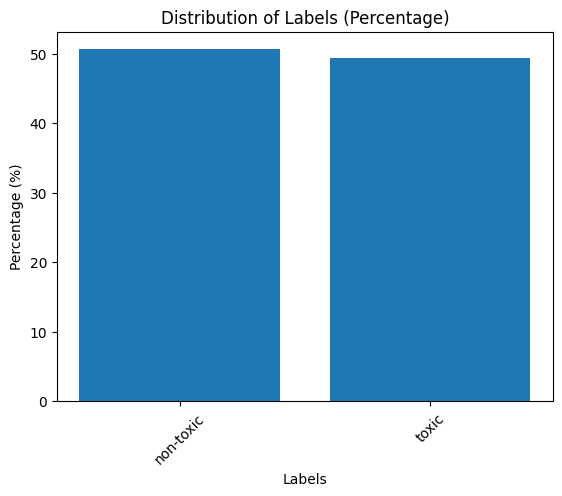

In [31]:
label_counts = Counter(label for _, label in data_binary)
total = sum(label_counts.values())
label_percentages = {label: (count / total) * 100 for label, count in label_counts.items()}

plt.bar(label_percentages.keys(), label_percentages.values())
plt.xlabel('Labels')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Labels (Percentage)')
plt.xticks(rotation=45)
plt.show()

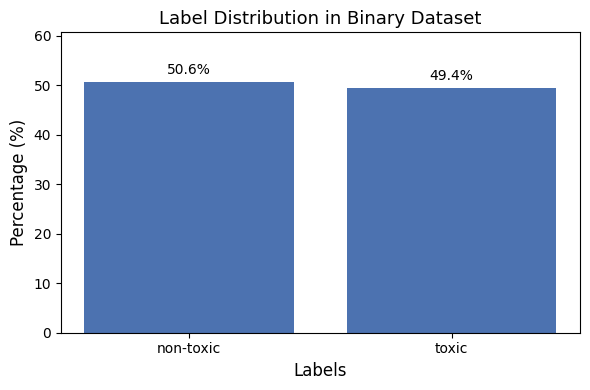

In [33]:
import matplotlib.pyplot as plt
from collections import Counter

# Count and percentage
label_counts = Counter(label for _, label in data_binary)
total = sum(label_counts.values())
label_percentages = {label: (count / total) * 100 for label, count in label_counts.items()}

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(label_percentages.keys(), label_percentages.values(), color="#4C72B0")

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', 
            ha='center', va='bottom', fontsize=10)

# Aesthetics
ax.set_xlabel('Labels', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Label Distribution in Binary Dataset', fontsize=13)
ax.set_ylim(0, max(label_percentages.values()) + 10)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# Data Augmentation

In [ ]:
# Set your API key
openai.api_key = "api-key" # alternative : use gpt online 

# Output paths
toxic_path = '../augmented_data/combined-toxic.csv'
non_toxic_path = '../augmented_data/combined-non-toxic.csv'

# Define content themes
toxic_themes = [
    "racist insult", "xenophobic comment", "dog-whistle about minorities",
    "conspiracy targeting outgroups", "coded political hate", "antisemitic trope",
    "homophobic undertone", "sexist stereotype"
]

nontoxic_themes = [
    "everyday frustrations", "inclusive message", "light sarcasm", "neutral personal update",
    "work-related stress", "supportive opinion", "mild swearing in humor", "relatable complaint"
]

# Build prompt templates
def build_prompt(theme, label):
    if label == "toxic":
        return (
            f"Write a short social media post (1–2 sentences) that expresses '{theme}' "
            f"in a subtle, implicit, or disguised way. Avoid using explicit slurs. "
            f"The post should sound realistic and resemble content someone might write online to evade moderation."
        )
    else:
        return (
            f"Write a short, realistic social media post (1–2 sentences) about '{theme}'. "
            f"It can include humor, sarcasm, or mild profanity, but should not sound toxic or hateful."
        )

def generate_post(theme, label, model="gpt-4", temperature=0.9, max_tokens=80):
    prompt = build_prompt(theme, label)
    try:
        response = openai.ChatCompletion.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=temperature,
            max_tokens=max_tokens,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"[ERROR] Theme: {theme}, Label: {label}, Error: {e}")
        return None


# Load generation and paraphrasing models
generator = pipeline("text-generation", model="gpt2", device=0)  # use -1 if no GPU
paraphraser = pipeline("text2text-generation", model="Vamsi/T5_Paraphrase_Paws", device=0)

# Curse words and template prompts
curse_words = ["fuck", "shit", "damn", "bitch", "asshole", "hell", "crap"]
frames = [
    "Write a sentence with the word '{word}' that is frustrated but not hateful:",
    "Use the word '{word}' in a casual, non-toxic sentence:",
    "Make a funny or exaggerated sentence using '{word}' in a non-offensive way:"
]

PROMPTS = [frame.format(word=w) for w in curse_words for frame in frames]

# Clean sentence after generation
def clean_sentence(text, max_sentences=2):
    sentences = re.findall(r'[^.!?]*[.!?]', text)
    clean = ' '.join(sentences[:max_sentences]).strip()
    return clean if clean else text.strip()

# Simple profanity filter
def contains_profane_word(text, profane_words=None):
    profane_words = profane_words or set(curse_words)
    return any(re.search(rf"\b{re.escape(word)}\b", text.lower()) for word in profane_words)

def try_paraphrase(text, paraphraser):
    try:
        response = paraphraser(f"paraphrase: {text}", max_length=60, do_sample=True, top_k=120, top_p=0.95, num_return_sequences=1)
        return response[0]['generated_text'].strip()
    except:
        return None

def generate_profane_non_toxic(generator, prompts, paraphraser=None, n_per_prompt=5, max_length=50):
    results = []

    for prompt in prompts:
        try:
            outputs = generator(prompt, max_length=max_length, num_return_sequences=n_per_prompt, do_sample=True, temperature=0.95, pad_token_id=50256)
        except Exception as e:
            print(f"Error generating from prompt: {prompt}\n{e}")
            continue

        for out in outputs:
            full_text = out["generated_text"]
            generated = full_text.replace(prompt, "").strip()
            clean = clean_sentence(generated)

            if len(clean.split()) >= 5 and contains_profane_word(clean):
                results.append({
                    "text": clean,
                    "label": "non-toxic",
                    "source": "synthetic_profanity",
                    "paraphrased": False,
                    "prompt": prompt
                })

                # Try paraphrasing
                if paraphraser:
                    paraphrased = try_paraphrase(clean, paraphraser)
                    if paraphrased and contains_profane_word(paraphrased):
                        results.append({
                            "text": paraphrased,
                            "label": "non-toxic",
                            "source": "synthetic_profanity_paraphrased",
                            "paraphrased": True,
                            "prompt": prompt
                        })
    return results

def generate_examples(label, themes, n_samples, outfile):
    examples = []
    for _ in tqdm(range(n_samples), desc=f"Generating {label}"):
        theme = random.choice(themes)
        text = generate_post(theme, label)
        if text:
            examples.append([text, label])
    # Save to CSV
    with open(outfile, "w", newline='', encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["text", "label"])
        writer.writerows(examples)
    print(f"✅ Saved {label} samples to {outfile}")


In [ ]:
# Run both generations
# generate_examples("toxic", toxic_themes, n_samples=150, outfile=toxic_path)
# generate_examples("non-toxic", nontoxic_themes, n_samples=150, outfile=non_toxic_path)

In [ ]:
not_toxic_path = '../augmented_data/combined-non-toxic.csv'
toxic_path = '../augmented_data/combined-toxic.csv'

# csv to list
not_toxic_extra= pd.read_csv(not_toxic_path)['text'].tolist()
toxic_extra = pd.read_csv(toxic_path)['text'].tolist()

In [4]:
len(not_toxic_extra), len(toxic_extra)


(152, 206)